In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(RO_LO_pwr=16, ef_amp=1.5, ro_freq=6.72739, qubit_id=q1, ef_ssm=-0.25684, IQ_angle=205, ge_amp=0.82, ef_time=49, ge_time=81, qubit_thr=[-10000, -600], ROIF=0.10268999999999995, ro_amp=1, RO_IF=None, ro_dur=5000, ge_ssm=-0.1144, RO_LO=6.6247)
Qubit(RO_LO_pwr=16, ef_amp=1, ro_freq=6.65554, qubit_id=q2, ef_ssm=-0.2962, IQ_angle=85, ge_amp=0.82, ef_time=None, ge_time=45, qubit_thr=[-10000, 1900], ROIF=0.030840000000000423, ro_amp=1.5, RO_IF=None, ro_dur=5000, ge_ssm=-0.154, RO_LO=6.6247)


In [12]:
def run_rabi_ef_swap(
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    swap_amp: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, swap_amp
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_ef_freq(ef_freq: list, amp: float):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("ef_swap_freq_data", "probs")
    values_folder = os.path.join("ef_swap_freq_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 1000
    sweep_time = 20000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    swap_amp = 1.36

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}
    q1.ef_amp = amp
    # Loop over frequencies and populate the dictionary
    for ef_frequency in ef_freq:
        prob_filename = os.path.join(probs_folder, f"freq={ef_frequency:.5f}.pkl")
        values_filename = os.path.join(values_folder, f"freq={ef_frequency:.5f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[ef_frequency] = df_prob
            return_vals[ef_frequency] = values
            continue  # Skip to the next J value

        q1.ef_ssm = ef_frequency
        df_prob, df_pop, values = run_rabi_ef_swap(
            num_steps, sweep_time, swap_freq, swap_time, swap_amp, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[ef_frequency] = df_prob
        return_vals[ef_frequency] = values

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [14]:
ef_start_freq = -0.2560
ef_end_freq = -0.2575
ef_amp = 0.02
steps = 16

ef_freqs = np.linspace(ef_start_freq, ef_end_freq, steps)
prob_dict, values_dict = sweep_ef_freq(ef_freqs, ef_amp)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 1000
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.513786 sec
Captured 17 buffers (2.609849 buffers per sec)
Captured 52224 records (8017.457327 records per sec)
Transferred 855638016 bytes (131358020.840419 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error


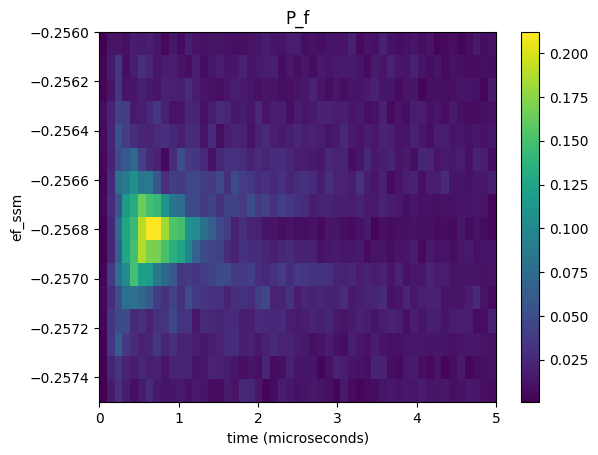

In [16]:
p_f = np.zeros((steps, 51))
for i in range(steps):
    p_f[i] = prob_dict[ef_freqs[i]][
        "P_f"
    ]  # / ( probability_dataframes[J_vals[i]]["P_f"]+ probability_dataframes[J_vals[i]]["P_e"])
plt.imshow(p_f, extent=[0, 5, ef_end_freq, ef_start_freq], aspect="auto")
plt.colorbar()
plt.ylabel("ef_ssm")
plt.xlabel("time (microseconds)")
plt.title("P_f")
plt.show()

In [ ]:
prob_dict

{-0.255:       time     P_f     P_e     P_g
 0.00  0.00  0.0176  0.8082  0.1742
 0.04  0.04  0.0252  0.7536  0.2212
 0.08  0.08  0.0450  0.7070  0.2480
 0.12  0.12  0.0450  0.6746  0.2804
 0.16  0.16  0.0982  0.6072  0.2946
 0.20  0.20  0.1244  0.5614  0.3142
 0.24  0.24  0.1360  0.5274  0.3366
 0.28  0.28  0.2088  0.4424  0.3488
 0.32  0.32  0.2366  0.4036  0.3598
 0.36  0.36  0.2974  0.3320  0.3706
 0.40  0.40  0.2902  0.3146  0.3952
 0.44  0.44  0.3818  0.2264  0.3918
 0.48  0.48  0.3590  0.2436  0.3974
 0.52  0.52  0.4150  0.1882  0.3968
 0.56  0.56  0.4238  0.1690  0.4072
 0.60  0.60  0.4746  0.1366  0.3888
 0.64  0.64  0.4714  0.1424  0.3862
 0.68  0.68  0.4644  0.1470  0.3886
 0.72  0.72  0.4828  0.1408  0.3764
 0.76  0.76  0.4586  0.1454  0.3960
 0.80  0.80  0.4364  0.1618  0.4018
 0.84  0.84  0.4166  0.1774  0.4060
 0.88  0.88  0.3958  0.2024  0.4018
 0.92  0.92  0.3656  0.2194  0.4150
 0.96  0.96  0.3046  0.2714  0.4240
 1.00  1.00  0.3098  0.2550  0.4352
 1.04  1.04  0.2614 